In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.modeling import fitting, Parameter
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
import corner
from MUSE_Models import Gaussian1D_OIII, Moffat2D_OIII, MUSE_3D_OIII, MUSE_3D_residual
%config InlineBackend.figure_format = 'retina'

#flux density (10^-20 erg/s/cm2/A/arcsec2)

In [2]:
# functions

data = ascii.read("M87_data/wavelength.txt", names=["wavelength"])
wavelength = np.array(data["wavelength"])

# Open Fits file and assign to tdata
hdulist = fits.open("M87_data/M87_rescube.fits")
Flux_data = (hdulist[0].data)
# Reshape into a datacube 318x315x271
Flux_data = np.array(Flux_data).reshape((318, 315, 271))

Moffat2D_data = ascii.read("exported_data/Fit results table.txt")
# Read in x and y coordinates, in reagrds to 318x315 map.
x_PNe = np.array(Moffat2D_data["x"])
y_PNe = np.array(Moffat2D_data["y"])
x_y_list = [[i,j] for i,j in zip(x_PNe, y_PNe)]


# Retrieve the respective spectra for each PNe source
n_pixels=16
X_AOI, Y_AOI = np.mgrid[:n_pixels,:n_pixels]
coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

flatten = lambda l: [item for sublist in l for item in sublist]
std_MUSE = 1.16
   
def raw_PNe_spectra_extract(x, y, n_pix, data):
    x = round(x)
    y = round(y)
    offset = round((0.5*n_pix))
    left_x = x - offset
    right_x = x + offset
    top_y = y - offset
    bottom_y = y + offset
    # select the spectra of interest
    PNe_spectra_from_data = data[int(top_y):int(bottom_y), int(left_x):int(right_x),:]
    raw_PNe_list = PNe_spectra_from_data.reshape(n_pix**2, 271)
    
    return raw_PNe_list

In [3]:
hdul_data = fits.open("exported_data/PNe sim all v4 raw spectra list.fits")
PNe_sim_read_in = hdul_data[0].data
PNe_sim_read_in = np.array(PNe_sim_read_in[:,0])
PNe_sim_read_in.shape


(470, 256, 271)

In [4]:
gamma_init = 4.225 #- 0.5 #4.225
alpha_init = 1.423 #- 0.5 #1.423

In [ ]:
error_cube_total = np.zeros(100170)

for i, spectra in enumerate(Flux_data_flat):
    error_cube_total[i] = np.std(spectra[142:])
    
error_cube_total_shape = error_cube_total.reshape(318,315)

In [5]:
# old
# Chi Square function
def chi_square(residuals, A_var):
    chi_sq = [np.sum(item**2) for item in residuals]

    ndof = len(wavelength) - 4 # number of degrees of freedom.
    chi_2_r = np.divide(chi_sq, ndof) # Reduced Chi square
    factor = np.sqrt(chi_2_r)
    err = np.sqrt(A_var) * factor

    return chi_sq, chi_2_r, err


fitter = fitting.LevMarLSQFitter()
gauss_params = [] # for best-fitting parameters
list_of_residuals = np.zeros((len(PNe_sim_read_in), 256, len(wavelength))) # for residuals
A_err = np.zeros((len(PNe_sim_read_in), 256))
A_by_rN = np.zeros((len(PNe_sim_read_in), 256))
F_err = np.zeros((len(PNe_sim_read_in), 256))
F_weights = np.zeros((len(PNe_sim_read_in), 256))
Gauss_F = np.zeros((len(PNe_sim_read_in), 256))
cov_x_A_var = np.zeros((len(PNe_sim_read_in), 256))
Gauss_std = np.zeros((len(PNe_sim_read_in),256))

f = FloatProgress(min=0, max=470, description="Fitting:", bar_style='info')
display(f)

cov_x = [] # storing the covariant matrix from each fit.
param_cov = []
for j,PNe in enumerate(PNe_sim_read_in):
    f.value +=1
    gauss_params = []
    for i,spectra in enumerate(PNe):
        gauss_init = Gaussian1D_OIII(amplitude=30., mean=5007, stddev=0.0, bkg=0.1, grad=0.001, fixed={"stddev":True})
        gauss_fit = fitter(gauss_init, wavelength, spectra, maxiter=10000000)
        list_of_residuals[j,i] = fitter.fit_info["fvec"]
        gauss_params.append(gauss_fit.parameters)
        cov_x.append(fitter.fit_info["cov_x"])
        param_cov.append(fitter.fit_info["param_cov"])


    g_amplitudes = [np.abs(item[0]) for item in gauss_params]
    g_means = [item[1] for item in gauss_params]
    g_stddev = [item[2] for item in gauss_params]
    
    for c in cov_x:
        if c is not None:
            cov_x_A_var[j] = c[0][0]
        elif c == None:
            cov_x_A_var[j] = 0.0
            
    # Calculate the Residual noise.
    list_of_res_N = [np.std(item) for item in list_of_residuals[j]]
    list_of_res_N = np.array(list_of_res_N)


    chi_sq, chi_sq_r, A_err[j] = chi_square(list_of_residuals[j], cov_x_A_var[j])

    Gauss_A = np.array(g_amplitudes)

    # Gaussian standard deviations, applying instrumental
    Gauss_std[j] = np.sqrt(np.array(g_stddev)**2 + std_MUSE**2)
 
    # 1D Gaussian Fluxes calculated from amplitudes and stddev
    Gauss_F[j] = np.array(Gauss_A) * np.sqrt(2*np.pi) * Gauss_std[j]
    F_err = Gauss_F[j] *np.sqrt( (A_err / Gauss_A)**2)
                                
    # The following checks are to clear inf and nan values 1D data, reducing potential 2D fitting errors.
    F_err[F_err == 0.0] = 100
    F_err[np.isnan(F_err)] = 100

    # Calculate the wieghts for initial 2D fitting run.
    F_weights[j] = 1 / F_err[j]
    # Amplitude divided by Residual Noise
    A_by_rN[j] = Gauss_A / list_of_res_N


FloatProgress(value=0.0, bar_style='info', description='Fitting:', max=470.0)

In [15]:
# Old 2D fitting section
def AOI(x, y, size):
    x = round(x)
    y = round(y)
    far_left = x - size
    far_right = x + size
    top = y - size
    bottom = y + size
    return int(far_left), int(far_right), int(top), int(bottom)

# Function returning an array containing the area of interest.

def AOI_Array_selection(array, far_left, far_right, top, bottom):
    return array[top:bottom, far_left:far_right]

# Function to flatten an array.

flatten = lambda l: [item for sublist in l for item in sublist]

def second_third_prep(array, fitted_model):
    res_flat = flatten(np.abs(array - fitted_model))
    rN = np.std(res_flat)
    array_flat = flatten(array)
    weights_flat = []
    outlier_marking = []
    
    for item, i in zip(res_flat, array_flat):
        if (np.abs(item) > 3*rN) or (i == 0):
            weights_flat.append(1e-6)
        else:
            weights_flat.append(1)

    for item, i in zip(res_flat, array_flat):
        if item > 3*rN:
            outlier_marking.append(i)
        else:
            outlier_marking.append(None)

    return weights_flat, outlier_marking, rN


def chi_square_test(residuals, error):
    chi_square = np.sum((residuals / error)**2) # Chi-square statistic test
    ndof = len(residuals) - 4. # Number of degrees of freedom, 4 being the number of free parameters used for fitting.
    chi_2_r = chi_square / ndof # Reduced Chi Square Statistic, used for goodness of fit evaluation.
    
    return chi_square, chi_2_r


def fitting_process(list_of_x_y, flux_map, flux_weights):
   

    run_number = 1
    
    for item in np.arange(0,1):
        
        # Select Flux Area Of Interest
        AOI_array = flux_map
        AOI_array_flat = flatten(AOI_array)
        
        # First set of weights created from F_weights using AOI coordinates
        AOI_weights = flux_weights
        
        # 1st fit
        m_init = Moffat2D_OIII(amplitude=np.max(AOI_array), x_0=8., y_0=8., bkg=1., gamma=gamma_init, alpha=alpha_init)#, fixed={"gamma":True, "alpha":True})
        m_fit = fitter(m_init, x_fit, y_fit, AOI_array_flat, maxiter=10000000, weights=AOI_weights)
        # Include a check for it fitted amplitude is 3*rN, else assign Null values

        # 2nd fit
        outlier_removal_1 = second_third_prep(np.array(AOI_array), np.array(m_fit(X_AOI,Y_AOI)))
        m_fit_2nd = fitter(m_init, x_fit, y_fit, AOI_array_flat, weights=outlier_removal_1[0], maxiter=100000000)
        
        # 3rd fit
        outlier_removal_2 = second_third_prep(np.array(AOI_array), np.array(m_fit_2nd(X_AOI,Y_AOI)))
        m_fit_3rd = fitter(m_init, x_fit, y_fit, AOI_array_flat, weights=outlier_removal_2[0], maxiter=100000000)
        
        fit_x = round(m_fit_3rd.x_0.value)
        fit_y = round(m_fit_3rd.y_0.value)
        
        
        model_minus_bkg = (m_fit_3rd(X_AOI, Y_AOI)- np.abs(m_fit_3rd.bkg.value)) # fit minus background
        f_5007 = np.sum(model_minus_bkg) * 1e-20 # total flux of PNe
        m_5007 = -2.5 * np.log10(f_5007) - 13.74 # apparent magnitude
        dM = 5 * np.log10(16.5) + 25 # Distance Modulus assuming 14.5 MPc
        M_5007 = m_5007 - dM # Absolute Magnitude
        
        AOI_array_flat[AOI_array_flat == np.nan] = 0.0
        
        x_c_m_3rd = m_fit_3rd.x_0.value
        y_c_m_3rd = m_fit_3rd.y_0.value
        r_moff_3rd = np.sqrt((x_fit - x_c_m_3rd)**2 + (y_fit - y_c_m_3rd)**2)

        wspace=0.5
        hspace=0.3
        
        run_number +=1
        
    #fit_A_by_rN = (m_fit_3rd.amplitude.value/(np.sqrt(2*np.pi)*1.16)) / outlier_removal_2[2]
    fit_A_by_rN = (np.max(m_fit_3rd(X_AOI, Y_AOI))/(np.sqrt(2*np.pi)*1.16)) / outlier_removal_2[2]
    
    return m_fit_3rd.amplitude.value, outlier_removal_2[2], fit_A_by_rN, f_5007, m_5007, M_5007


Moffat2D_data = ascii.read("exported_data/Fit results table.txt")

# Read in x and y coordinates, in reagrds to 318x315 map.
x_PNe = np.array(Moffat2D_data["x"])
y_PNe = np.array(Moffat2D_data["y"])
x_y_list = [[i,j] for i,j in zip(x_PNe, y_PNe)]

x_y_size = 16
# Area of Interest coordinates setup: meshgrid for plotting, x_fit and y_fit for fitting 30x30 grid.
X_AOI, Y_AOI = np.mgrid[:x_y_size,:x_y_size]


coordinates = [(n,m) for n in range(x_y_size) for m in range(x_y_size)]

x_fit = [item[0] for item in coordinates]
y_fit = [item[1] for item in coordinates]

Gauss_F_shape = np.zeros((len(PNe_sim_read_in),16,16))
for k,PNe in enumerate(Gauss_F):
    Gauss_F_shape[k] = PNe.reshape(16,16)

fit_A = np.zeros(len(PNe_sim_read_in))
fit_rN = np.zeros(len(PNe_sim_read_in))
fit_A_by_rN = np.zeros(len(PNe_sim_read_in))
f_5007_list = np.zeros(len(PNe_sim_read_in))
m_5007_list = np.zeros(len(PNe_sim_read_in))
M_5007_list = np.zeros(len(PNe_sim_read_in))

t = FloatProgress(min=0, max=(470), description="Fitting:", bar_style='info')
display(t)
for l,PNe in enumerate(Gauss_F_shape):
    result = fitting_process(x_y_list, PNe, F_weights[l])
    fit_A[l] = result[0]
    fit_rN[l]= result[1]
    fit_A_by_rN[l] = result[2]
    f_5007_list[l] = result[3]
    m_5007_list[l] = result[4]
    M_5007_list[l] = result[5]
    t.value += 1


FloatProgress(value=0.0, bar_style='info', description='Fitting:', max=470.0)

C:\Users\tspri\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log10
C:\Users\tspri\Documents\GitHub\Gaussian-Fit-MUSE-PNe\MUSE_Models.py:44: RuntimeWarning: overflow encountered in power
  return amplitude * (1 + rr_gg)**(-alpha) + bkg


In [12]:
#New

# store values
PNe_df = pd.DataFrame(columns=("PNe number", "Total Flux", "V (km/s)", "m_5007", "M_5007","A/rN", "red chi"))
PNe_df["PNe number"] = np.arange(1,len(x_PNe)+1)
# .loc(Row, column name)

error_cube = np.zeros((470, n_pixels**2, len(wavelength)))

for PNe_num in np.arange(0, 470):
    PNe_data = PNe_sim_read_in[PNe_num]
    list_of_std = [np.abs(np.std(spec[140:])) for spec in PNe_data]
    error_cube[PNe_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

params = Parameters()
params.add('moffat_amp', value=50., min=0.0)
params.add('x_0', value=8, min=0., max=n_pixels)
params.add('y_0', value=8, min=0., max=n_pixels)
params.add('gamma', value=gamma_init, min=0., max=20., vary=True) 
params.add("alpha", value=alpha_init, min=0., max=20., vary=True) 
params.add("mean", value=5007., min=4980, max=5030)
params.add("Gauss_std", value=1.16, vary=False, min=1.0, max=1.6) # LSF, instrumental resolution.
params.add("Gauss_bkg",  value=1., min=-100., max=10.)
params.add("Gauss_grad", value=1., min=-2., max=2.)

list_of_A_OIII = np.zeros(470)
list_of_resids = np.zeros(470)
list_of_F_OIII_xy = np.zeros((470, 256))

best_x_fit = np.zeros(470)
best_y_fit = np.zeros(470)
c = 299792458
list_of_M_amp = np.zeros(470)
total_F = np.zeros(470)

h = FloatProgress(min=0, max=470, description="Fitting:", bar_style='info')
display(h)
for i,PNe in enumerate(PNe_sim_read_in):
    useful_stuff = []
    results = minimize(MUSE_3D_residual, params, args=(wavelength, x_fit, y_fit, PNe, error_cube[i], i, useful_stuff), nan_policy="propagate")
    #model = MUSE_3D_OIII(results.params, wavelength, x_fit, y_fit, PNe, useful_stuff)
#print(np.array(model[4]).shape)
#print(results.params["gamma"])
#print(results.params["alpha"])
#print(results.params["moffat_amp"])

    total_F[i] = useful_stuff[0][0]
    list_of_resids[i] = useful_stuff[0][1]
    list_of_A_OIII[i] = useful_stuff[0][2]
    list_of_F_OIII_xy[i] = useful_stuff[0][3]
    h.value += 1
#list_of_M_amp[0] = results.params["moffat_amp"]
#PNe_df["V (km/s)"] = (c * (results.params["mean"] - 5007.0) / 5007.0) / 1000
#PNe_df["red chi"] = results.redchi
#best_x_fit[0] = results.params["x_0"]
#best_y_fit[0] = results.params["y_0"]


FloatProgress(value=0.0, bar_style='info', description='Fitting:', max=470.0)

(470,)


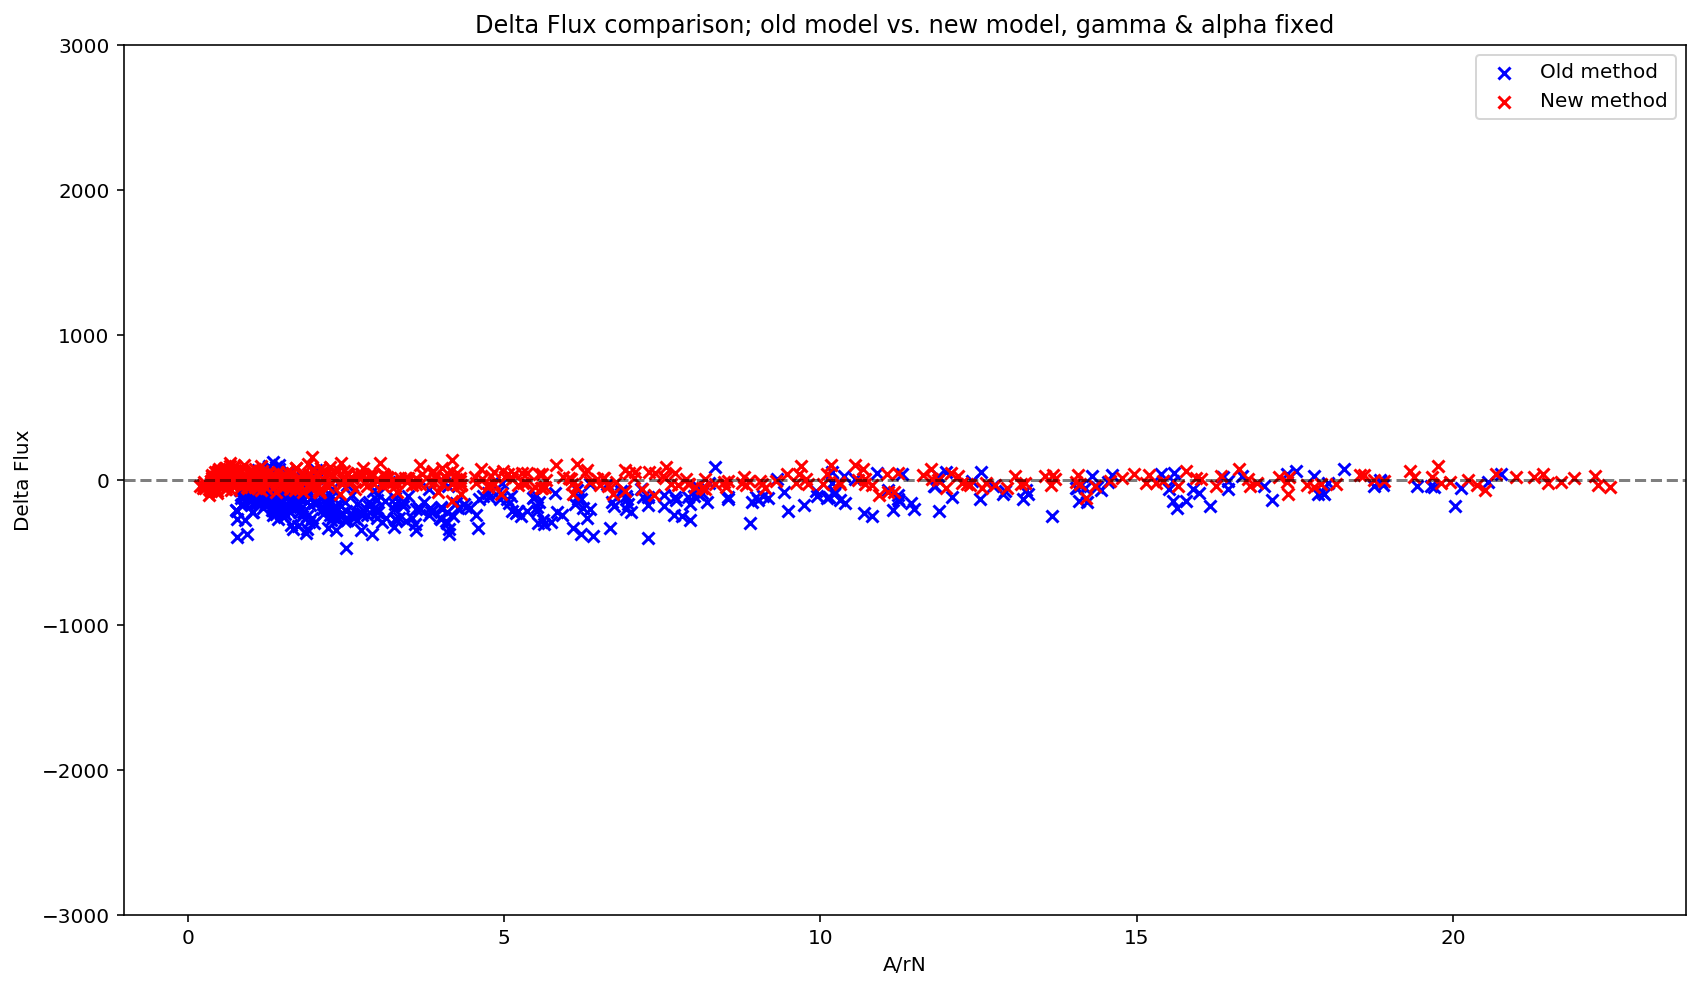

In [14]:
#print(total_F)
#print(total_F[0])
A_rN_new = list_of_A_OIII / list_of_resids
print(A_rN_new.shape)

# read in sim input fluxes
input_fluxes = np.load("exported_data/sim_input_fluxes.npy")

# Old method comparison; out minus in
delta_flux_old = f_5007_list[:] - input_fluxes

# New method comparison
delta_flux_new = total_F - input_fluxes

# plot
plt.figure(figsize=(14,8))
plt.scatter(fit_A_by_rN, delta_flux_old/1e-20, marker="x", c="blue", label="Old method")
plt.scatter(A_rN_new, delta_flux_new/1e-20, marker="x", c="red", label="New method")
plt.ylim(-3000,3000)
plt.axhline(y=0, c="k", ls="--", alpha=0.5)
plt.ylabel("Delta Flux")
plt.xlabel("A/rN")
plt.legend()
plt.title("Delta Flux comparison; old model vs. new model, gamma & alpha fixed")
#plt.savefig("Plots/delta_F_g_a_fixed.png")

(470,)


C:\Users\tspri\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


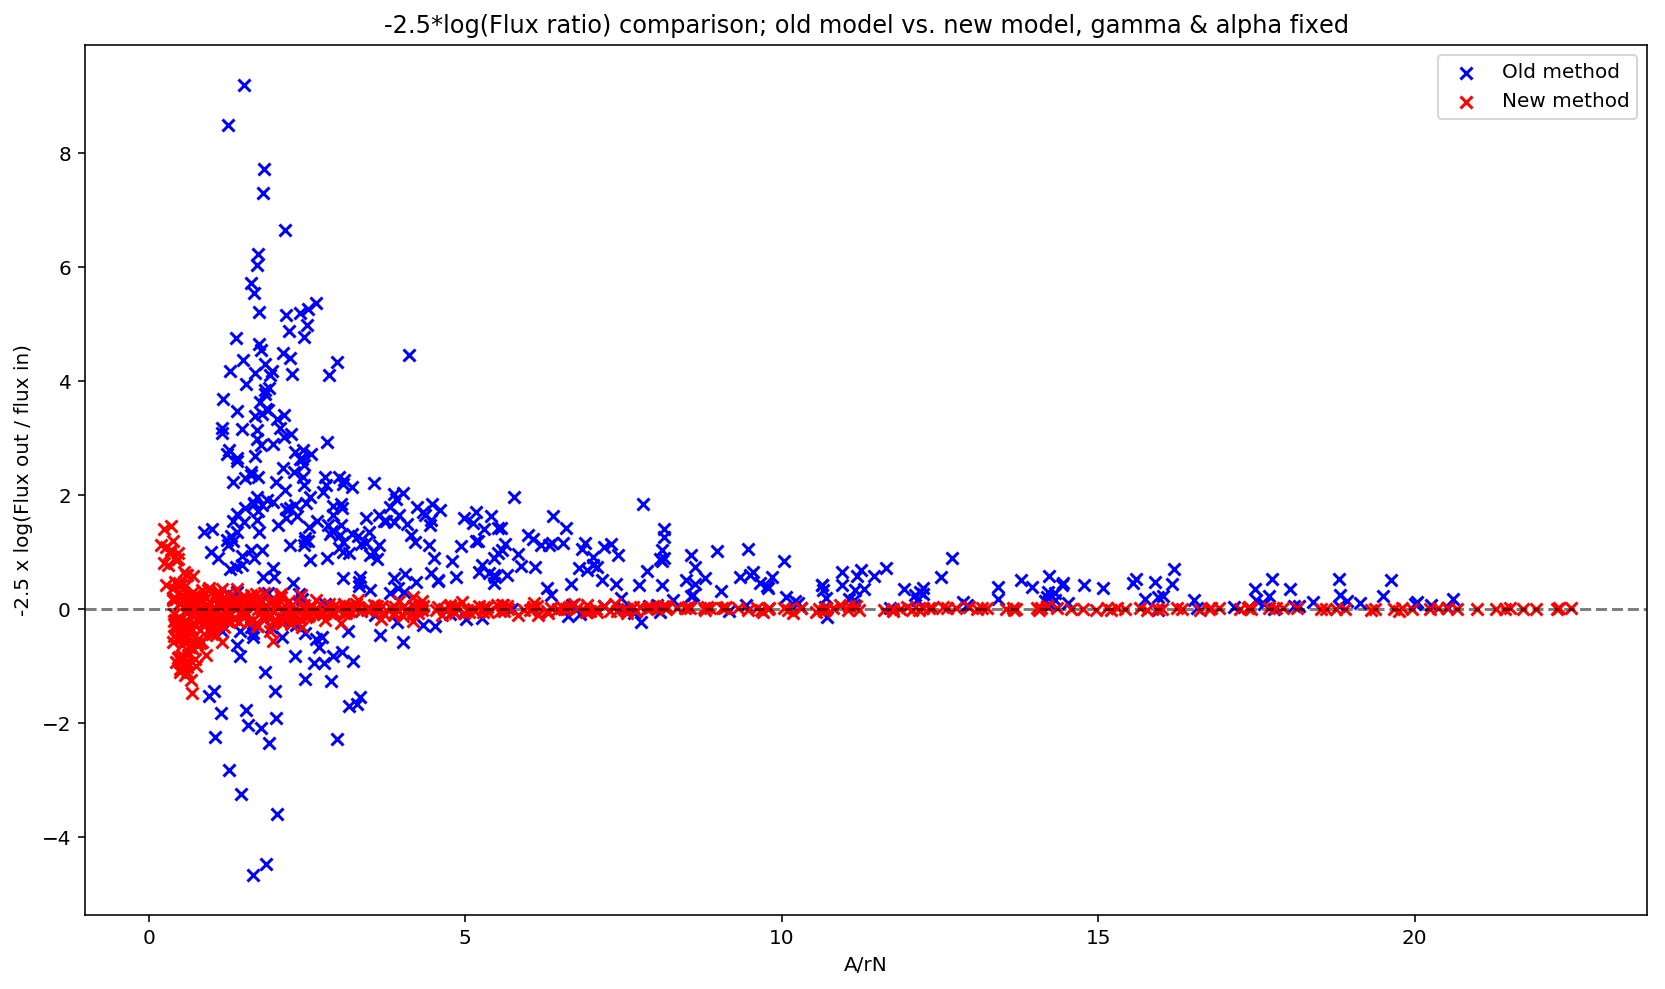

In [25]:
#print(total_F)
#print(total_F[0])
A_rN_new = list_of_A_OIII / list_of_resids
print(A_rN_new.shape)

# read in sim input fluxes
input_fluxes = np.load("exported_data/sim_input_fluxes.npy")

# Old method comparison; out minus in
ratio_flux_old = f_5007_list / input_fluxes
old_to_plot = -2.5 * np.log(ratio_flux_old)

# New method comparison
ratio_flux_new = total_F / input_fluxes
new_to_plot = -2.5 * np.log(ratio_flux_new)

# plot
plt.figure(figsize=(14,8))
plt.scatter(fit_A_by_rN, old_to_plot, marker="x", c="blue", label="Old method")
plt.scatter(A_rN_new, new_to_plot, marker="x", c="red", label="New method")
#plt.ylim(-3000,3000)
plt.axhline(y=0, c="k", ls="--", alpha=0.5)
plt.ylabel("-2.5 x log(Flux out / flux in)")
plt.xlabel("A/rN")
plt.legend()
plt.title("-2.5*log(Flux ratio) comparison; old model vs. new model, gamma & alpha fixed")
plt.savefig("Plots/log_ratio_F_g_a_fixed.png")